Çalışma dizini: /Users/sevvalarslan/projects/SkinDataset
Tüm görüntüler toplandı: 10015 adet
Metadata satır sayısı: 10015
Kullanılabilir görüntü sayısı: 10015
Train: 7017, Val: 1499, Test: 1499
DataLoader hazır!
Epoch 1/10
Train Loss: 1.0540 | Train Acc: 0.6607 | Train F1: 0.2000
Val Acc: 0.6991 | Val F1: 0.2616
----------------------------------------
Epoch 2/10
Train Loss: 0.8118 | Train Acc: 0.7020 | Train F1: 0.2983
Val Acc: 0.7018 | Val F1: 0.2711
----------------------------------------
Epoch 3/10
Train Loss: 0.7720 | Train Acc: 0.7164 | Train F1: 0.3862
Val Acc: 0.7118 | Val F1: 0.3165
----------------------------------------
Epoch 4/10
Train Loss: 0.7328 | Train Acc: 0.7285 | Train F1: 0.4105
Val Acc: 0.7211 | Val F1: 0.3847
----------------------------------------
Epoch 5/10
Train Loss: 0.7127 | Train Acc: 0.7358 | Train F1: 0.4305
Val Acc: 0.7378 | Val F1: 0.4177
----------------------------------------
Epoch 6/10
Train Loss: 0.6880 | Train Acc: 0.7425 | Train F1: 0.4548
Val 

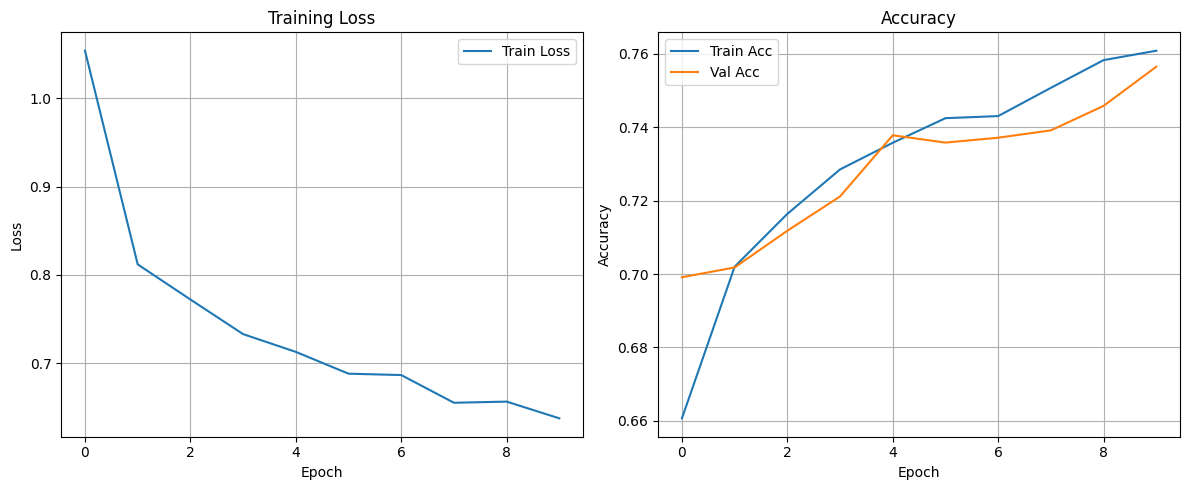

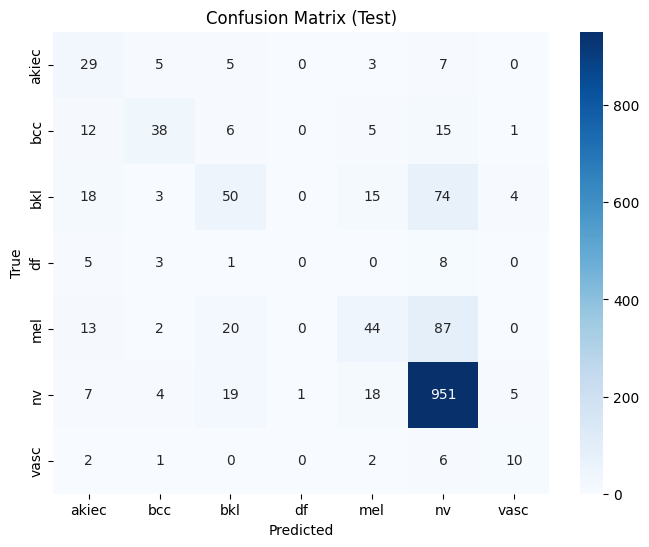

Classification Report:
               precision    recall  f1-score   support

       akiec       0.34      0.59      0.43        49
         bcc       0.68      0.49      0.57        77
         bkl       0.50      0.30      0.38       164
          df       0.00      0.00      0.00        17
         mel       0.51      0.27      0.35       166
          nv       0.83      0.95      0.88      1005
        vasc       0.50      0.48      0.49        21

    accuracy                           0.75      1499
   macro avg       0.48      0.44      0.44      1499
weighted avg       0.72      0.75      0.72      1499



In [1]:
import os
import random
import csv
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
import shutil

os.chdir("/Users/sevvalarslan/projects/SkinDataset")
print("Çalışma dizini:", os.getcwd())

src_dirs = []
dst_dir = "all_images"
os.makedirs(dst_dir, exist_ok=True)

for folder in src_dirs:
    folder_path = os.path.join(os.getcwd(), folder)
    for file in os.listdir(folder_path):
        src_path = os.path.join(folder_path, file)
        dst_path = os.path.join(dst_dir, file)
        if not os.path.exists(dst_path):
            shutil.copy(src_path, dst_path)

print(f"Tüm görüntüler toplandı: {len(os.listdir(dst_dir))} adet")

metadata_file = "HAM10000_metadata.csv"
metadata = []

with open(metadata_file, newline="", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for row in reader:
        metadata.append(row)

print("Metadata satır sayısı:", len(metadata))

label_map = {
    "akiec": 0,
    "bcc": 1,
    "bkl": 2,
    "df": 3,
    "mel": 4,
    "nv": 5,
    "vasc": 6
}

class_names = list(label_map.keys())

data_list = []

for item in metadata:
    img_id = item["image_id"]
    label = label_map[item["dx"]]
    img_path = os.path.join(dst_dir, img_id + ".jpg")

    if os.path.exists(img_path):
        data_list.append((img_path, label))

print(f"Kullanılabilir görüntü sayısı: {len(data_list)}")

class_groups = {i: [] for i in range(7)}
for path, label in data_list:
    class_groups[label].append((path, label))

train_list, val_list, test_list = [], [], []

for label, items in class_groups.items():
    random.shuffle(items)
    n = len(items)
    test_n = int(n * 0.15)
    val_n = int(n * 0.15)
    test_list.extend(items[:test_n])
    val_list.extend(items[test_n:test_n+val_n])
    train_list.extend(items[test_n+val_n:])

random.shuffle(train_list)
random.shuffle(val_list)
random.shuffle(test_list)

print(f"Train: {len(train_list)}, Val: {len(val_list)}, Test: {len(test_list)}")

IMG_SIZE = 128

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

class SkinDataset(Dataset):
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        img_path, label = self.data_list[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

train_dataset = SkinDataset(train_list, transform=train_transform)
val_dataset = SkinDataset(val_list, transform=val_test_transform)
test_dataset = SkinDataset(test_list, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("DataLoader hazır!")

class BaseModel1(nn.Module):
    def __init__(self):
        super(BaseModel1, self).__init__()
        self.conv = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(16 * (IMG_SIZE // 2) * (IMG_SIZE // 2), 128)
        self.fc2 = nn.Linear(128, 7)

    def forward(self, x):
        x = F.relu(self.conv(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BaseModel1().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_epoch():
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu())
        all_labels.extend(y.cpu())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")
    return total_loss / len(train_loader), acc, f1

def eval_epoch(loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu())
            all_labels.extend(y.cpu())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")
    return acc, f1

EPOCHS = 10
train_losses, train_accs, val_accs = [], [], []

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc, train_f1 = train_epoch()
    val_acc, val_f1 = eval_epoch(val_loader)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train F1: {train_f1:.4f}")
    print(f"Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")
    print("-" * 40)

test_acc, test_f1 = eval_epoch(test_loader)
print("TEST Accuracy:", test_acc)
print("TEST F1:", test_f1)

def plot_training_curves():
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(train_losses, label="Train Loss")
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid()
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_accs, label="Train Acc")
    plt.plot(val_accs, label="Val Acc")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_curves()

def plot_confusion_matrix_and_report():
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            preds = model(X).argmax(dim=1)
            all_preds.extend(preds.cpu())
            all_labels.extend(y.cpu())

    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix (Test)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    
    report = classification_report(all_labels, all_preds, target_names=class_names)
    print("Classification Report:\n", report)

plot_confusion_matrix_and_report()

torch.save(model.state_dict(), "skin_lesion_classifier.pth")
